---

In [1]:
from pathlib import Path

path = Path().absolute()

In [2]:
cd ../

c:\Users\c10nGp4\OneDrive\Documents\GitHub\imbalance-multi-classification


In [3]:
import pickle
import time

from sklearn.pipeline import Pipeline

---

### Load Data
---

In [4]:
import pandas as pd

# Load dataset
training_set_df = pd.read_csv(path / "assets/datasets/training-set-1.csv", delimiter=";")
testing_set_df = pd.read_csv(path / "assets/datasets/testing-set-1.csv", delimiter=";")

# Get X and y from dataset
X_train = list(training_set_df["texts"])
y_train = list(training_set_df["targets"])

X_test = list(testing_set_df["texts"])
y_test = list(testing_set_df["targets"])

### Data Preparation
---

In [5]:
from pipeline.text_cleaning import TextCleaning
from pipeline.tokenize_mwt_pos_lemma import TokenizeMWTPOSLemma

# Text Preprocessing

text_preprocessing_pipeline: Pipeline = Pipeline([
    ("text_cleaning", TextCleaning()),
    ("tokenize_mwt_pos_lemma", TokenizeMWTPOSLemma())
])

X_train = text_preprocessing_pipeline.transform(X_train)
X_test = text_preprocessing_pipeline.transform(X_test)

2023-06-06 20:53:33 INFO: DOWNLOAD STANZA MODEL


2023-06-06 20:53:33 INFO: Downloading default packages for language: id (Indonesian) ...
2023-06-06 20:53:34 INFO: File exists: C:\Users\c10nGp4\stanza_resources\id\default.zip
2023-06-06 20:53:36 INFO: Finished downloading models and saved to C:\Users\c10nGp4\stanza_resources.
2023-06-06 20:53:36 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-06-06 20:53:36 INFO: LOAD STANZA PIPELINE: tokenize,mwt,pos,lemma


2023-06-06 20:53:45 INFO: Loading these models for language: id (Indonesian):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| pos       | gsd     |
| lemma     | gsd     |

2023-06-06 20:53:45 INFO: Using device: cuda
2023-06-06 20:53:45 INFO: Loading: tokenize
2023-06-06 20:53:49 INFO: Loading: mwt
2023-06-06 20:53:49 INFO: Loading: pos
2023-06-06 20:53:49 INFO: Loading: lemma
2023-06-06 20:53:49 INFO: Done loading processors!


2023-06-06 20:53:49 INFO: TEXT CLEANING
2023-06-06 20:53:51 INFO: TOKENIZE, MWT, POS, LEMMA
2023-06-06 20:54:52 INFO: TEXT CLEANING
2023-06-06 20:54:52 INFO: TOKENIZE, MWT, POS, LEMMA


### Hyper-parameters tuning
---

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

from pipeline.pos_filter import POSFilter
from pipeline.stopword_removal import StopWordRemoval
from pipeline.document_transformer import DocumentTransformer

def fun(arg):
    return arg

tfidfvectorizer_hyperparameters = {
    "encoding": "ascii",
    "decode_error": "ignore",
    "strip_accents": "ascii",
    "preprocessor": fun,
    "tokenizer": fun,
    "analyzer": "word",
    "token_pattern": None,
    "ngram_range": (1, 2),
    "min_df": 5,
    "max_df": 1.0,
}

linearsvc_hyperparameters = {
    "penalty": "l1",
    "loss": "squared_hinge",
    "dual": False,
    "tol": 0.0001,
    "C": 0.1,
    "multi_class": "ovr",
    "fit_intercept": True,
    "intercept_scaling": 1000,
    "max_iter": 100000,
    "random_state": 42
}

pipeline: Pipeline = Pipeline([
    ("pos_filter", POSFilter()),
    ("document_transformer", DocumentTransformer()),
    ("tfidfvectorizer", TfidfVectorizer(**tfidfvectorizer_hyperparameters)),
    ("linearsvc", LinearSVC(random_state=42))
])

In [19]:
from pipeline.pos_filter import POS

param_distributions = {
    "pos_filter__pos": (POS, ("ADJ","ADV","NOUN","PART","VERB")),
    "document_transformer__feat_attrs": (["text"],["lemma"],["text","upos"],["lemma","upos"]),
    "tfidfvectorizer__norm": ("l1", "l2"),
    "tfidfvectorizer__sublinear_tf": (True, False),
    "linearsvc__class_weight": (None, "balanced")
}

In [20]:
from sklearn.metrics import make_scorer, accuracy_score, matthews_corrcoef
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearnex import config_context

n_iter = 1000
n_splits = 5
train_size = 0.8
n_jobs = 2
verbose = 3

randomized_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring=make_scorer(matthews_corrcoef),
    n_jobs=n_jobs,
    cv=StratifiedShuffleSplit(n_splits=n_splits, train_size=train_size, random_state=42),
    verbose=verbose,
    random_state=42
)

t0 = time.time()

with config_context(target_offload="auto", allow_fallback_to_host=True):
    randomized_search.fit(X_train, y_train)

estimation = time.time() - t0

cv_results_df = pd.DataFrame(randomized_search.cv_results_)

cv_results_df = cv_results_df.rename(lambda col_name: col_name.split("__")[-1] if "param_" in col_name else col_name, axis="columns")
cv_results_df = cv_results_df.reindex(columns=["pos","feat_attrs", "norm","sublinear_tf","class_weight","split0_test_score","split1_test_score","split2_test_score","split3_test_score","split4_test_score","mean_test_score","mean_fit_time","rank_test_score"])
cv_results_df = cv_results_df.fillna("None")

cv_results_df.to_csv(path / "assets/cv_results.csv", sep=";", index=False)

c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 64 is smaller than n_iter=1000. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 64 candidates, totalling 320 fits


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


2023-06-06 21:28:32 INFO: POS REMOVAL
2023-06-06 21:28:32 INFO: DOCUMENT TRANSFORMER


In [21]:
cv_results_df

,pos,feat_attrs,norm,sublinear_tf,class_weight,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,mean_fit_time,rank_test_score
0,"{SYM, X, CONJ, PUNCT, VERB, PROPN, ADP, PART, ...",[text],l1,True,None,0.662480,0.678608,0.670214,0.670793,0.663892,0.669197,0.938998,50
1,"{SYM, X, CONJ, PUNCT, VERB, PROPN, ADP, PART, ...",[text],l1,False,None,0.660484,0.675644,0.665897,0.669781,0.659541,0.666269,1.059827,52
2,"{SYM, X, CONJ, PUNCT, VERB, PROPN, ADP, PART, ...",[text],l2,True,None,0.690050,0.698101,0.675200,0.697022,0.690990,0.690273,1.034989,13
3,"{SYM, X, CONJ, PUNCT, VERB, PROPN, ADP, PART, ...",[text],l2,False,None,0.687057,0.692929,0.678064,0.691810,0.692837,0.688540,1.038944,18
4,"(ADJ, ADV, NOUN, PART, VERB)",[text],l1,True,None,0.664437,0.681575,0.670245,0.668900,0.662426,0.669517,1.060874,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,"{SYM, X, CONJ, PUNCT, VERB, PROPN, ADP, PART, ...","[lemma, upos]",l2,False,balanced,0.663392,0.679456,0.672184,0.674897,0.680673,0.674120,0.905879,44
60,"(ADJ, ADV, NOUN, PART, VERB)","[lemma, upos]",l1,True,balanced,0.679758,0.690403,0.683179,0.692734,0.689313,0.687078,0.945324,19
61,"(ADJ, ADV, NOUN, PART, VERB)","[lemma, upos]",l1,False,balanced,0.676410,0.682896,0.684541,0.689449,0.684259,0.683511,0.953069,23
62,"(ADJ, ADV, NOUN, PART, VERB)","[lemma, upos]",l2,True,balanced,0.665353,0.683724,0.674758,0.673140,0.680015,0.675398,0.889516,40


In [22]:
from datetime import timedelta

print(f'Fitted {randomized_search.n_splits_} folds of {len(cv_results_df)} candidates, finished in {str(timedelta(seconds=estimation))}.')
print(f"Best score: {randomized_search.best_score_}")
print("Best hyper-parameters:")
randomized_search.best_params_

Fitted 5 folds of 64 candidates, finished in 0:12:09.284261.
Best score: 0.7047316828988512
Best hyper-parameters:


{'tfidfvectorizer__sublinear_tf': True,
 'tfidfvectorizer__norm': 'l1',
 'pos_filter__pos': {'ADJ',
  'ADP',
  'ADV',
  'AUX',
  'CONJ',
  'DET',
  'INTJ',
  'NOUN',
  'NUM',
  'PART',
  'PRON',
  'PROPN',
  'PUNCT',
  'SCONJ',
  'SYM',
  'VERB',
  'X'},
 'linearsvc__class_weight': 'balanced',
 'document_transformer__feat_attrs': ['text']}

### Evaluation
---

In [23]:
y_pred = randomized_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

print("Accuracy:", accuracy)
print("MCC:", mcc)

2023-06-06 21:28:33 INFO: POS REMOVAL
2023-06-06 21:28:33 INFO: DOCUMENT TRANSFORMER
Accuracy: 0.7698390285230161
MCC: 0.7014825313981973


### Confusion Matrix
---

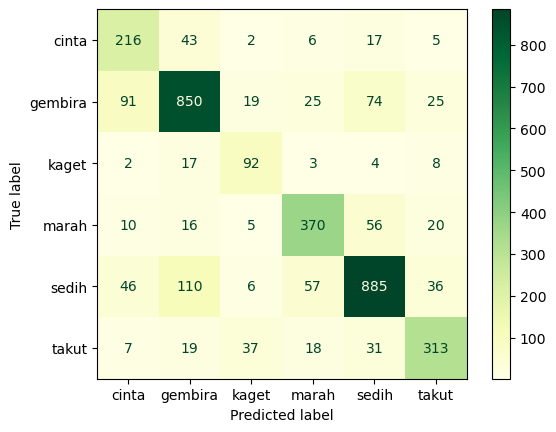

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

normalize = None
# normalize="true"

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize=normalize, cmap="YlGn")